In [4]:
#!/usr/bin/env python
# coding: utf-8

# ## Data Cleaning and Preprocessing

# In[44]:


# Import dependencies
import pandas as pd
import datetime
import time
#from sqlalchemy import create_engine
#from config import db_password


# In[45]:


# Read in files
df = pd.read_csv('/content/bitcoin_data.csv')


# In[46]:


# Display initial data
df.head(10)


# In[47]:


# Drop all nulls
# df = df.dropna()


# In[48]:


# keep timestamp, high, low, weighted_price
df = df[['Timestamp', 'High', 'Low', 'Volume_(BTC)', 'Weighted_Price']].reset_index(drop=True)
df


# In[49]:


# preprocessing notes-- consider omitting data prior to Jan 1st, 2012 due to higher volatility 
# earlier in bitcoin's lifecycle

# converting Timestamp column to str datatype
df['str_timestamp'] = [str(timestamp) for timestamp in df['Timestamp']]
df['int_timestamp'] = df['str_timestamp'].astype('int32', copy=True)

# filtering df to only include rows after 01/01/2012
df_cleaned_filtered = df.loc[df['int_timestamp'] >= 1325391360]
df_cleaned_filtered.head(2)


# In[50]:


# context manager to suppress 1 time SettingWithCopyWarning; alternatively call .loc after timestamp conversion to avoid error
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    df_cleaned_filtered['UTC_time'] = df_cleaned_filtered['int_timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

# .strftime('%Y-%m-%d %H:%M:%S')
    
# Convert from Unix to UTC time
#df_cleaned_filtered['UTC_time'] = df_cleaned_filtered['int_timestamp'].\
#    apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))


# In[51]:


# dropping all null values, followed by evaluation of which time periods had the greatest data loss
final_df = df_cleaned_filtered.dropna().reset_index(drop=True)

# finding percentage of data loss (null values)
btotalLength = (len(df_cleaned_filtered))
bpartialLength = (len(final_df))
bValuesDropped = btotalLength - bpartialLength
bitstampDiff = (btotalLength - bpartialLength) / btotalLength * 100 
totalDays = round(btotalLength/1440,2)
daysDropped = round(bValuesDropped/1440,2)

print(f"Percentage of total Bitstamp data lost due to dropping rows with NaN values: {bitstampDiff:.2f}%")
print(f"Ratio of Bitstamp rows dropped: {bValuesDropped:,}/{btotalLength:,}")
print(f"Total dataset contains {totalDays} days worth of data. Due to data loss, we had to drop {daysDropped} days worth of data")

# Machine learning section
# possible implementation ideas:
# 1. time series forecasting bitcoin price with ARIMA(Auto Regressive Integrated Moving Average)
# Rational for using time series: the 4 components of time series are trends, seasonality (consistent trends that span 1 calender year), noise/irregularity, and cyclicity(trends that can be observed in <1 or >1 year); this is perfect for tradeable assets 
# Qualifying criteria: the dataset must be stationary in order to more accurately fit a time series model. Stationary means that there should be a constant mean with constant std deviation or variance
# We can test if a time series is stationary by plotting the moving avg and/or movning std dev. to see if it changes over time. These results can be supported with an ADCF test
# if testing reveals our time series is NOT stationary, we can perform a variety of transformations to change it (log transform, sq rt, exponential decay etc..)
# SARIMA is ARIMA with a seasonality component. 


# ### PGAdmin SQL Schema

# In[56]:


# db schema thoughts: can create multiple tables for each currency (1 for btc, 1 ethereum, 1 xrp)
# can also add in additional tables down the line to support our analysis (table with google analytics, table with twitter search results for sentiment analysis)


# In[57]:


# View final dataset column names
final_df.head(5)


# In[58]:


# Rename columns to be sql friendly
final_df.rename({'Timestamp':'timestamp',
                  'High':'high',
                  'Low':'low',
                  'Volume_(BTC)':'volume',
                  'Weighted_Price':'weightedPrice',
                  'str_timestamp':'timestampSTR',
                  'int_timestamp':'timestampINT',
                  'UTC_time':'timeUTC',
                  'time_delta':'timeDelta'
                 }, axis='columns', inplace=True)


# Checking datatypes
final_df.dtypes


# In[61]:


# Verifying final dataframe
final_df.head(2)

Percentage of total Bitstamp data lost due to dropping rows with NaN values: 27.14%
Ratio of Bitstamp rows dropped: 1,240,496/4,571,033
Total dataset contains 3174.33 days worth of data. Due to data loss, we had to drop 861.46 days worth of data


,timestamp,high,low,volume,weightedPrice,timestampSTR,timestampINT,timeUTC
0,1325391360,4.58,4.58,1.502,4.58,1325391360,1325391360,2012-01-01 04:16:00
1,1325431680,4.84,4.84,10.000,4.84,1325431680,1325431680,2012-01-01 15:28:00


In [5]:
# importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima import auto_arima as AA
import warnings
import os
#from statsmodels.tsa.statespace.sarimax import SARIMAX
import regex as re

date_price_df = final_df[['timeUTC','weightedPrice']]
btc_2012_to_2017_df = date_price_df[date_price_df['timeUTC'].dt.date <= pd.to_datetime('2017-01-01')]

y_2012 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2012-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2013-01-01'))]
y_2013 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2013-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2014-01-01'))]
y_2014 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2014-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2015-01-01'))]
y_2015 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2015-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2016-01-01'))]
y_2016 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2016-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2017-01-01'))]
y_2017 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2017-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2018-01-01'))]

y=btc_2012_to_2017_df.set_index(['timeUTC'])
#y.sort_index(inplace=True)
#y.dropna(inplace=True)
#y['weightedPrice']
y_2012.head()

,timeUTC,weightedPrice
0,2012-01-01 04:16:00,4.58
1,2012-01-01 15:28:00,4.84
2,2012-01-01 22:45:00,5.00
3,2012-01-02 20:04:00,5.00
4,2012-01-03 11:45:00,5.32


In [6]:
y_2012 = y_2012.set_index(['timeUTC'])
y_2013 = y_2013.set_index(['timeUTC'])
y_2014 = y_2014.set_index(['timeUTC'])
y_2015 = y_2015.set_index(['timeUTC'])
y_2016 = y_2016.set_index(['timeUTC'])
y_2017 = y_2017.set_index(['timeUTC'])

In [7]:
print(f'length of data:\n 2012: {len(y_2012)}\n 2013: {len(y_2013)}\n 2014: {len(y_2014)}\n 2015: {len(y_2015)}\n 2016: {len(y_2016)}\n 2017: {len(y_2017)}')

length of data:
 2012: 26629
 2013: 319761
 2014: 398176
 2015: 372735
 2016: 352099
 2017: 841


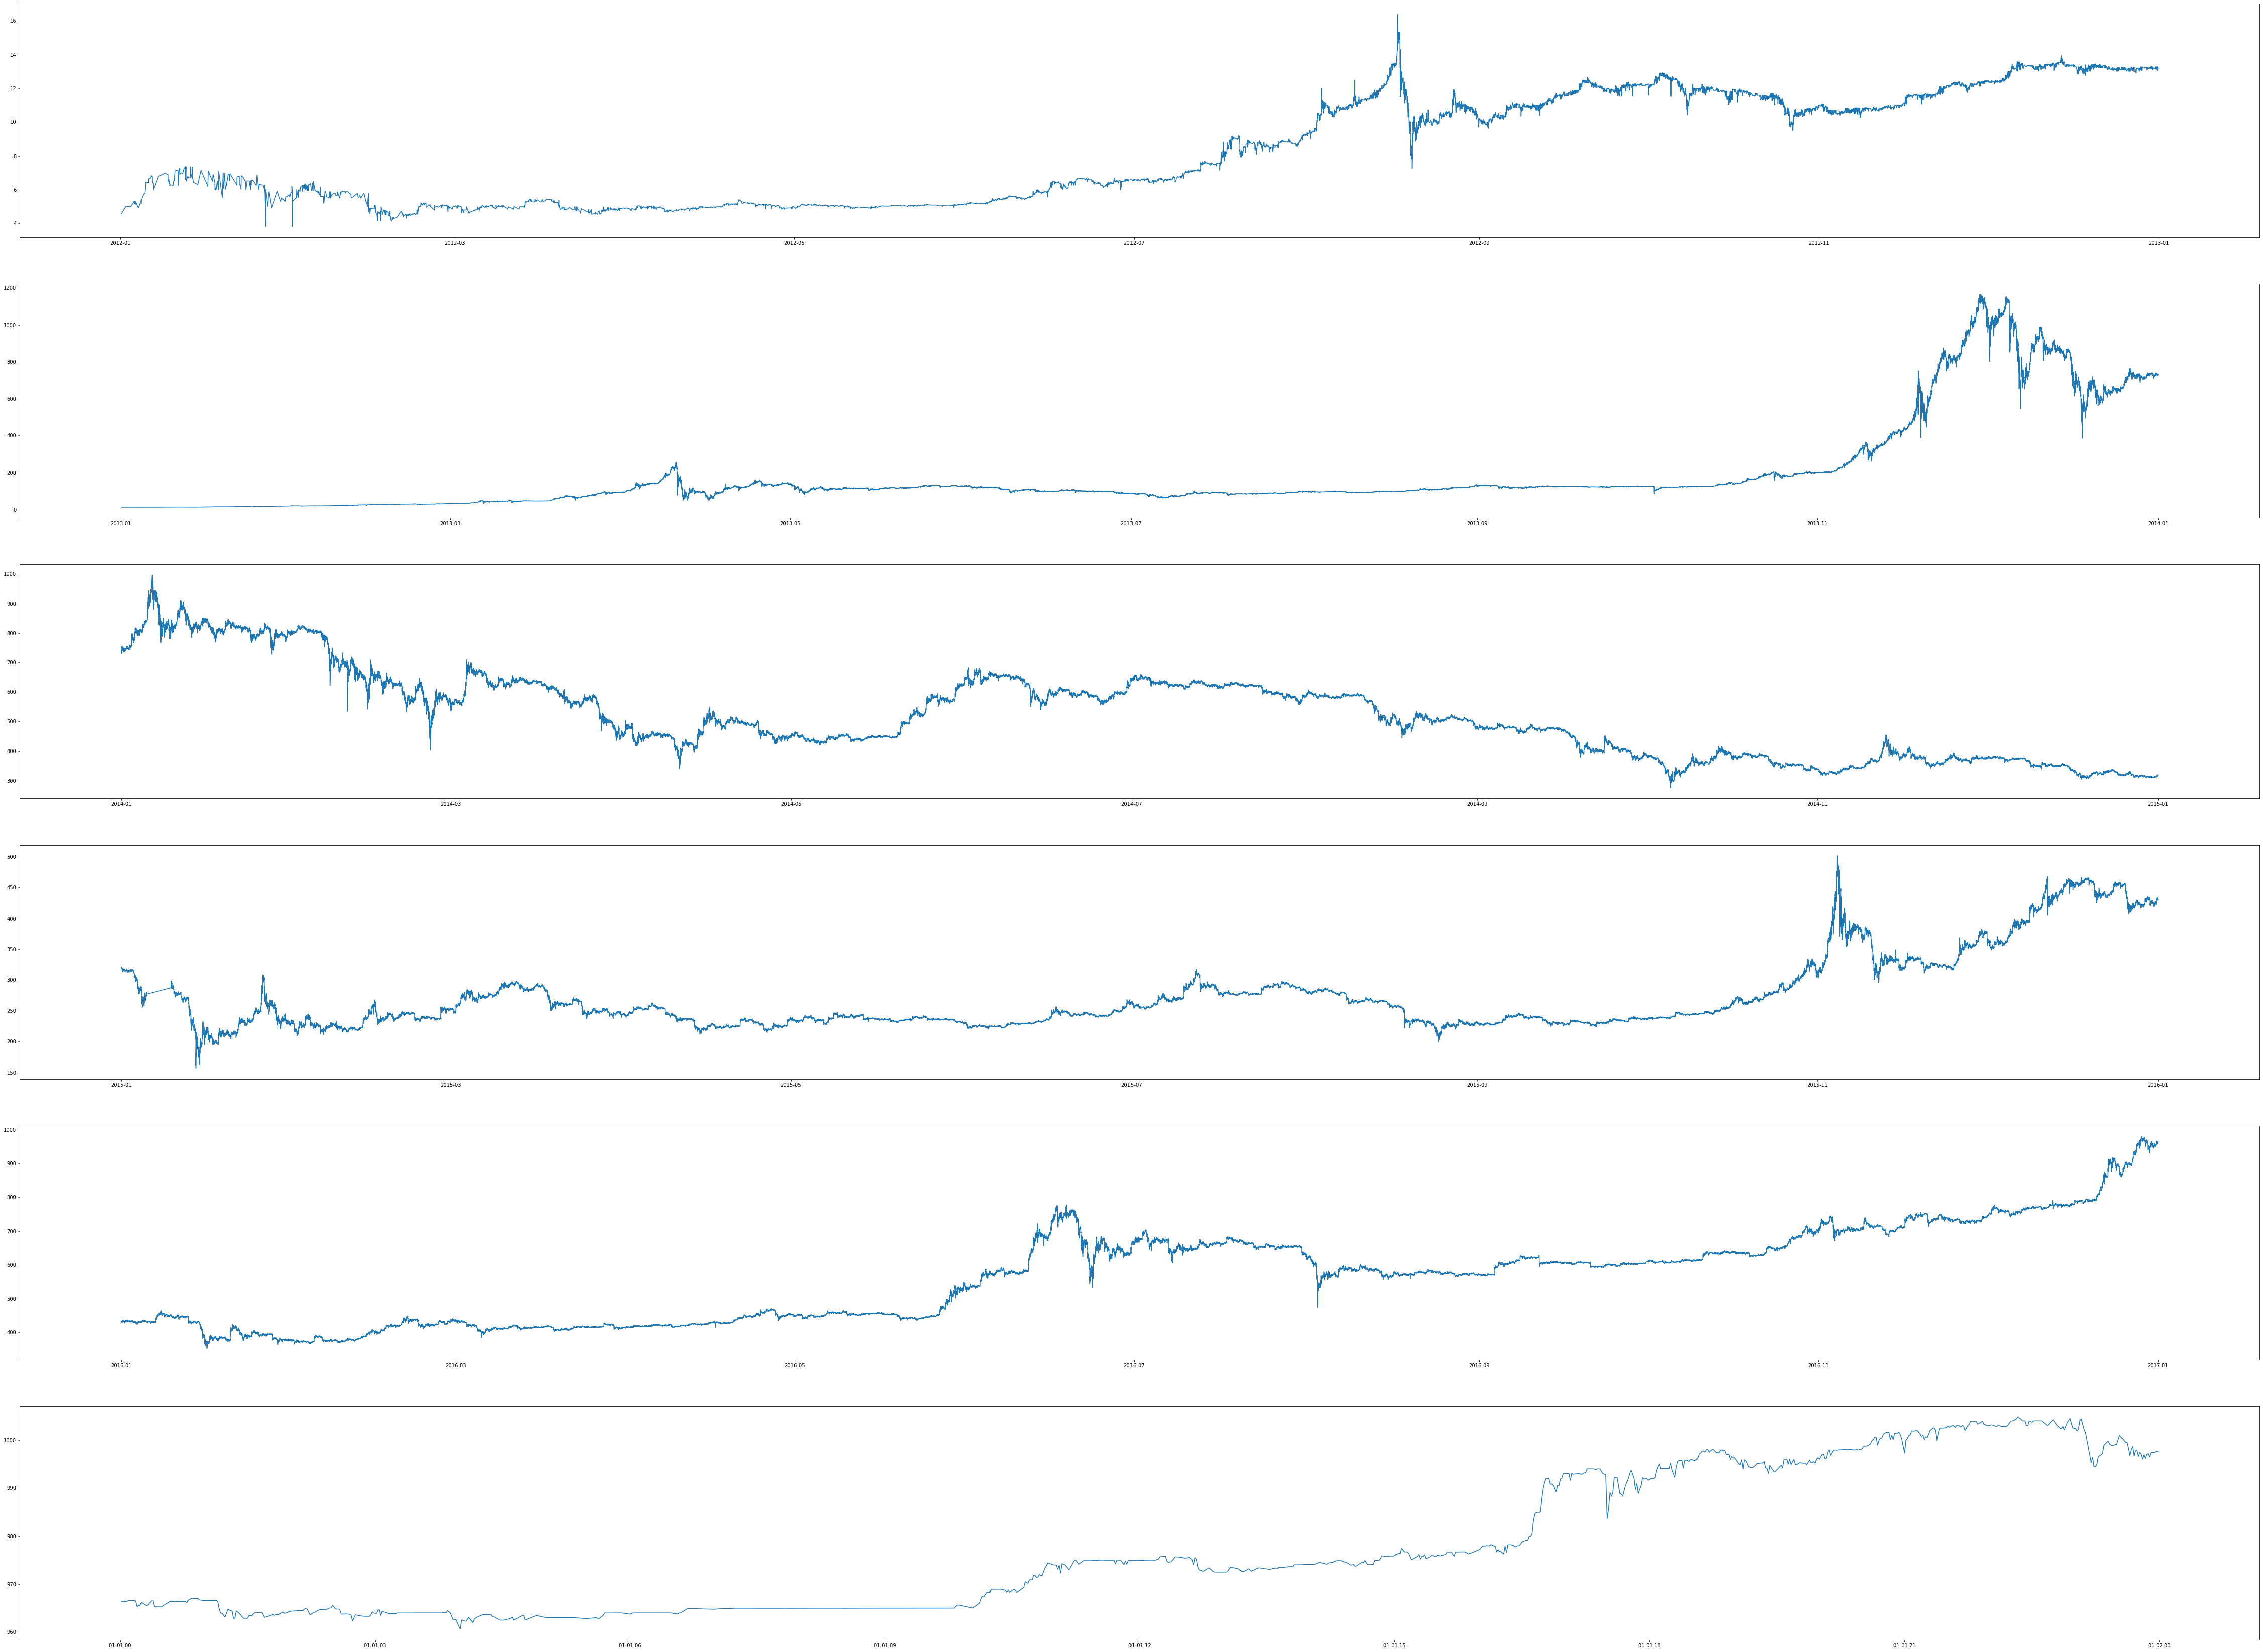

In [8]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6, figsize=(80, 60))
#y_2012.plot(figsize=(19, 4))
ax1.plot(y_2012)
ax2.plot(y_2013)
ax3.plot(y_2014)
ax4.plot(y_2015)
ax5.plot(y_2016)
ax6.plot(y_2017)

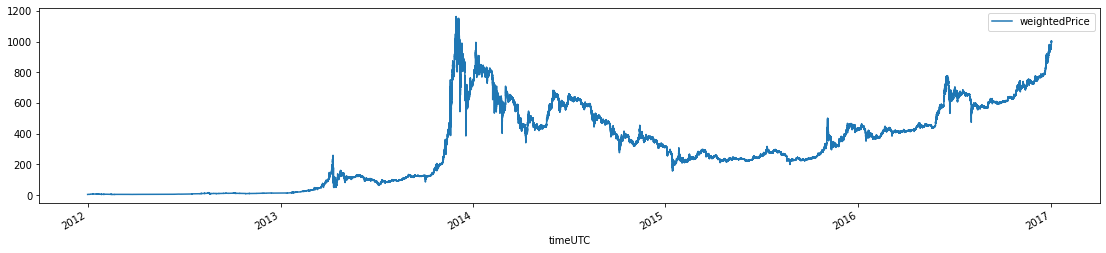

In [9]:
y.plot(figsize=(19, 4))
plt.show()

In [10]:
print(len(y))

1470241


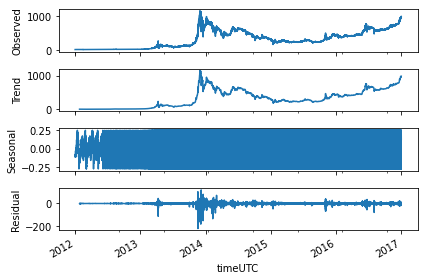

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(x=y['weightedPrice'], model='additive', freq=800)
fig = decomposition.plot()
plt.show()

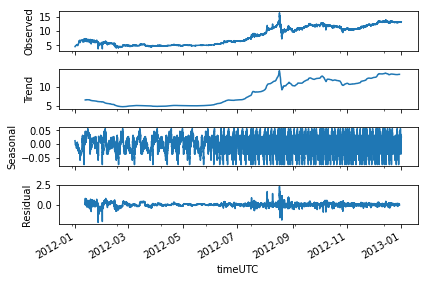

In [12]:
decomposition = seasonal_decompose(x=y_2012, model='additive', freq=365)
fig = decomposition.plot()
plt.show()

In [13]:
# importing and setting dependencies
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from statsmodels.tsa.statespace.sarimax import SARIMAX

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [7]:



p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))




Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y_2012,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:200562.1829542828
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:164348.0753368032
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-18251.555209327482
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-19320.654286587313
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-18249.845866966414
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-19275.120146724388
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-19292.77381117941
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-19361.215791799354
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:164036.28101748912
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:128635.71248426527
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-29955.709945471437
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-32913.382909678425
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-29953.102287633013
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-32854.02527751977
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-32667.883031302204
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-32970.91709339694
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-54014.4131093678
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-5402

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y_2016,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y_2015,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

In [17]:
# getting best model parameters based on AIC (lower the better)
#ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-57092.14646812964
#ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-57099
mod = sm.tsa.statespace.SARIMAX(y_2012,
                                order=(0, 1, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3771      0.001   -337.588      0.000      -0.379      -0.375
ar.S.L12   -5.083e-05   9.06e-05     -0.561      0.575      -0.000       0.000
sigma2         0.0069   1.04e-05    661.858      0.000       0.007       0.007


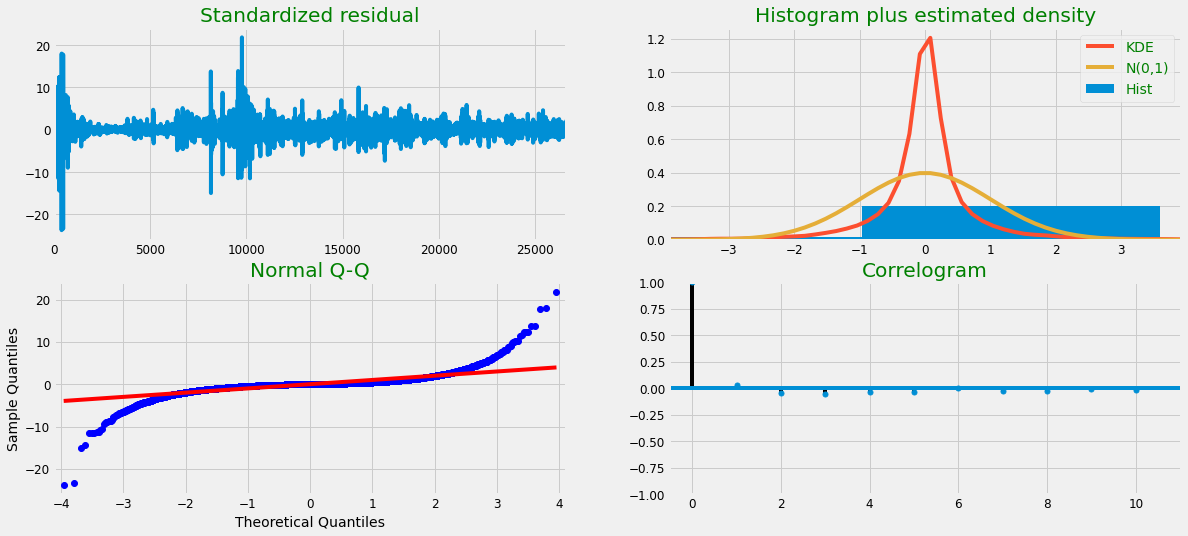

In [18]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [15]:
mod = sm.tsa.statespace.SARIMAX(y_2012,
                                order=(0, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3770      0.001   -336.993      0.000      -0.379      -0.375
ar.S.L12      -0.3370      0.077     -4.366      0.000      -0.488      -0.186
ma.S.L12       0.3333      0.077      4.311      0.000       0.182       0.485
sigma2         0.0068   1.03e-05    662.049      0.000       0.007       0.007


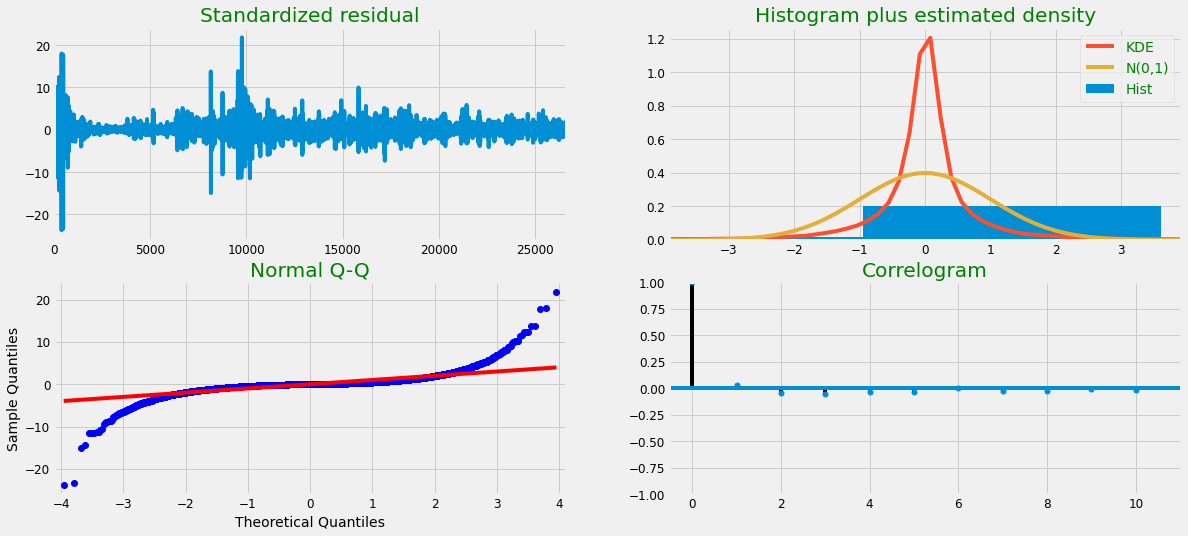

In [16]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

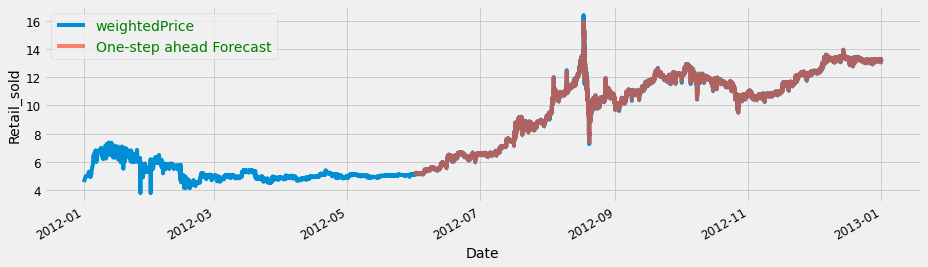

In [27]:
# comparing true values with forecast predictions
pred = results.get_prediction(start=pd.to_datetime('2012-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y_2012.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [30]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax2 = y_2012.plot(figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax2, label='Forecast')
ax2.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax2.set_xlabel('Date')
ax2.set_ylabel('Sales')
plt.legend()
plt.show()

ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f741a2b3bf8> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 1008x288 with 1 Axes>

In [31]:
# truth values of dataset
y_forecasted = pred.predicted_mean
y_forecasted.head(12)

timeUTC
2012-06-01 00:00:00    5.163317
2012-06-01 01:30:00    5.167481
2012-06-01 02:02:00    5.175279
2012-06-01 06:13:00    5.182628
2012-06-01 06:14:00    5.180993
2012-06-01 06:26:00    5.174147
2012-06-01 06:37:00    5.184018
2012-06-01 08:52:00    5.175287
2012-06-01 08:57:00    5.190679
2012-06-01 09:01:00    5.184027
2012-06-01 10:41:00    5.170831
2012-06-01 10:46:00    5.188998
dtype: float64

In [32]:
# visualizes upper and lower boundaries 
pred_ci.head(24)

,lower weightedPrice,upper weightedPrice
26629,13.065619,13.390091
26630,13.036723,13.418988
26631,13.011656,13.444056
26632,12.989207,13.466506
26633,12.968696,13.487019
26634,12.949694,13.506023
26635,12.931909,13.523809
26636,12.915124,13.540576
26637,12.899203,13.556496
26638,12.884025,13.571686
